In [2]:
%matplotlib inline
import math
import random
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.stats.stats import pearsonr

from sklearn.cross_validation import train_test_split
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz
from numpy.random import randint 
from sklearn.model_selection import cross_validate
from imblearn.under_sampling import RandomUnderSampler
import collections

In [3]:
#creazione di average_daily_hours, time_spenT_company, work_accident e departments
df = pd.read_csv("HR_comma_sep.csv")
df['average_daily_hours']=df['average_montly_hours']/21.5
df=df.drop(['average_montly_hours'], axis=1)

df ['time_spent_company'] = df['time_spend_company']
df=df.drop(['time_spend_company'], axis=1)

df ['work_accident'] = df['Work_accident']
df=df.drop(['Work_accident'], axis=1)

df ['departments'] = df['sales']
df=df.drop(['sales'], axis=1)

df.head()

,satisfaction_level,last_evaluation,number_project,left,promotion_last_5years,salary,average_daily_hours,time_spent_company,work_accident,departments
0,0.38,0.53,2,1,0,low,7.302326,3,0,sales
1,0.80,0.86,5,1,0,medium,12.186047,6,0,sales
2,0.11,0.88,7,1,0,medium,12.651163,4,0,sales
3,0.72,0.87,5,1,0,low,10.372093,5,0,sales
4,0.37,0.52,2,1,0,low,7.395349,3,0,sales


In [4]:
# funzione per trasformare le variabile categoriche in numeriche dumpy/binarie (sklearn.DecisionTree funziona solo con numeri e fa solo due split per nodo)
def clean_data(df):
    # Get the unique values of departments
    departments_locs = sorted(df['departments'].unique())

    # Generate a mapping of departments from a string to a number representation        
    departments_locs_mapping = dict(zip(departments_locs, 
                                     range(0, len(departments_locs) + 1)))
    
    # Transform departments from a string to a number representation
    df['departments_val'] = df['departments'].map(departments_locs_mapping).astype(int)
    
    # Transform departments from a string to dummy variables
    df = pd.concat([df, pd.get_dummies(df['departments'], prefix='departments_val')], axis=1)
    
    # drop departments and departments_val
    df=df.drop(['departments'], axis=1)
    df=df.drop(['departments_val'], axis=1)
    
    
     # Get the unique values of salary
    salary_locs = sorted(df['salary'].unique())

    # Generate a mapping of salary from a string to a number representation        
    salary_locs_mapping = dict(zip(salary_locs, [2, 0, 1]))
    
    # Transform salary from a string to a number representation
    df['salary_val'] = df['salary'].map(salary_locs_mapping).astype(int)
    
    # Transform salary from a string to dummy variables
    df = pd.concat([df, pd.get_dummies(df['salary'], prefix='salary_val')], axis=1)
    
    # drop salary and salary_val
    df=df.drop(['salary'], axis=1)
    df=df.drop(['salary_val'], axis=1)
    return df
df= clean_data (df)

In [5]:
#creazione di un nuovo dataset da cui vengono eliminate alcune variabili che potrebbero non avere importanza nella classificazione
df_selected_feat=df.drop(['departments_val_IT', 'departments_val_RandD', 'departments_val_accounting','departments_val_hr', 'departments_val_management',      
'departments_val_marketing',        
'departments_val_product_mng',     
'departments_val_sales',          
'departments_val_support',          
'departments_val_technical'],axis=1)
df_selected_feat.head()

,satisfaction_level,last_evaluation,number_project,left,promotion_last_5years,average_daily_hours,time_spent_company,work_accident,salary_val_high,salary_val_low,salary_val_medium
0,0.38,0.53,2,1,0,7.302326,3,0,0,1,0
1,0.80,0.86,5,1,0,12.186047,6,0,0,0,1
2,0.11,0.88,7,1,0,12.651163,4,0,0,0,1
3,0.72,0.87,5,1,0,10.372093,5,0,0,1,0
4,0.37,0.52,2,1,0,7.395349,3,0,0,1,0


In [6]:
#divisione di df_selected_feat in training e test

# conversione del DataFrame in un numpy array:
train_data_sel = df_selected_feat.values

#DATASET NON BILANCIATO: CI SONO 3571 LEFT E 11428 NON LEFT
# selezione delle features senza la colonna left (target)
train_sel_features = np.delete(train_data_sel,np.s_[3:4], axis=1)

# selezione del target left
train_sel_target = np.delete(train_data_sel,np.s_[0:3], axis=1)
train_sel_target = train_sel_target[:, 0]

# divisione del DATASET SBILANCIATO in training e in test - tecnica holdout->1/3 per test set(train_x e test_x formano insieme tutto il dataset mentre train_y e test_y corrispondono al target)
train_sel_x, test_sel_x, train_sel_y, test_sel_y = train_test_split(train_sel_features, 
                                                    train_sel_target, 
                                                    test_size=0.33, 
                                                    random_state=0)




In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

In [8]:
clf = RandomForestClassifier(n_estimators=30)
param_grid = {"criterion":["gini","entropy"],
              "max_features":range(1,11),
              "max_depth": [2,3,4,5,6,7,8,9,10,11,12,None],
              "min_samples_split": range(10, 431),
              "bootstrap": [True]
             }
              


search = RandomizedSearchCV(clf, param_distributions=param_grid, scoring=make_scorer(accuracy_score), n_iter=100)

In [9]:
search.fit(train_sel_features, train_sel_target)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=1,
          param_distributions={'criterion': ['gini', 'entropy'], 'max_features': range(1, 11), 'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, None], 'min_samples_split': range(10, 431), 'bootstrap': [True]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=make_scorer(accuracy_score),
          verbose=0)

In [10]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [11]:
report(search.cv_results_, 3)

Model with rank: 1
Mean validation score: 0.978 (std: 0.003)
Parameters: {'min_samples_split': 38, 'max_features': 6, 'max_depth': 9, 'criterion': 'gini', 'bootstrap': True}

Model with rank: 2
Mean validation score: 0.978 (std: 0.003)
Parameters: {'min_samples_split': 30, 'max_features': 8, 'max_depth': 10, 'criterion': 'entropy', 'bootstrap': True}

Model with rank: 3
Mean validation score: 0.978 (std: 0.003)
Parameters: {'min_samples_split': 317, 'max_features': 8, 'max_depth': 10, 'criterion': 'gini', 'bootstrap': True}



In [12]:
search.best_estimator_.estimators_[0]

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
            max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=38, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1666303073, splitter='best')

In [13]:
#prova dell'albero ottenuto 
clf = tree.DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
            max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=38, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1666303073, splitter='best')
clf = clf.fit(train_sel_x, train_sel_y)
print ("DATASET SBILANCIATO--->")
print (clf.feature_importances_)

print("TRANING E TEST FORMATI CON HOLDOUT->")
train_sel_pred = clf.predict(train_sel_x)
test_sel_pred = clf.predict(test_sel_x)
# Accuratezza sul training e sul test
print ("Accuratezza sul training:")
print (metrics.accuracy_score(train_sel_y, train_sel_pred))
print ("Accuratezza sul test:")
print (metrics.accuracy_score(test_sel_y, test_sel_pred))
# recall, precision, f1_measure su training e su test
print ("r, p, f1-score sul training:")
print(classification_report(train_sel_y, 
                            train_sel_pred, 
                            target_names=['Not left', 'left']))
print ("r, p, f1-score sul test:")
print(classification_report(test_sel_y, 
                            test_sel_pred, 
                            target_names=['Not left', 'left']))

print("TRANING E TEST FORMATI CON CROSS-VALIDATION->")

scores = cross_validate(clf, 
                        train_sel_features, train_sel_target, scoring=['accuracy','recall','precision','f1'],
                        cv=10, return_train_score=True)

print ("Accuratezza test:")
print(scores['test_accuracy'])
print ('Accuratezza: %0.2f (+/- %0.2f)' % (scores['test_accuracy'].mean(), scores['test_accuracy'].std() * 2))
print ("Accuratezza training:")
print(scores['train_accuracy'])
print ('Accuratezza: %0.2f (+/- %0.2f)' % (scores['train_accuracy'].mean(), scores['train_accuracy'].std() * 2))
print ("Recall test:")
print(scores['test_recall'])
print ('Recall: %0.2f (+/- %0.2f)' % (scores['test_recall'].mean(), scores['test_recall'].std() * 2))
print ("Recall training:")
print(scores['train_recall'])
print ('Recall: %0.2f (+/- %0.2f)' % (scores['train_recall'].mean(), scores['train_recall'].std() * 2))
print ("Precision test:")
print(scores['test_precision'])
print ('Precision: %0.2f (+/- %0.2f)' % (scores['test_precision'].mean(), scores['test_precision'].std() * 2))
print ("Precision training:")
print(scores['train_precision'])
print ('Precision: %0.2f (+/- %0.2f)' % (scores['train_precision'].mean(), scores['train_precision'].std() * 2))
print ("f1 test:")
print(scores['test_f1'])
print ('F1: %0.2f (+/- %0.2f)' % (scores['test_f1'].mean(), scores['test_f1'].std() * 2))
print ("f1 training:")
print(scores['train_f1'])
print ('F1: %0.2f (+/- %0.2f)' % (scores['train_f1'].mean(), scores['train_f1'].std() * 2))


DATASET SBILANCIATO--->
[  5.30260008e-01   1.12363238e-01   9.66121750e-02   1.45148947e-04
   9.14130942e-02   1.67516690e-01   0.00000000e+00   1.67259267e-03
   1.70537878e-05   0.00000000e+00]
TRANING E TEST FORMATI CON HOLDOUT->
Accuratezza sul training:
0.979798984974
Accuratezza sul test:
0.977171717172
r, p, f1-score sul training:
             precision    recall  f1-score   support

   Not left       0.98      1.00      0.99      7610
       left       0.99      0.93      0.96      2439

avg / total       0.98      0.98      0.98     10049

r, p, f1-score sul test:
             precision    recall  f1-score   support

   Not left       0.98      0.99      0.99      3818
       left       0.98      0.92      0.95      1132

avg / total       0.98      0.98      0.98      4950

TRANING E TEST FORMATI CON CROSS-VALIDATION->
Accuratezza test:
[ 0.98201199  0.976       0.978       0.97533333  0.97733333  0.98066667
  0.97933333  0.974       0.98065377  0.97998666]
Accuratezza: 0.9

In [16]:
#Accuratezza di training e test DEL DATASET SBILANCIATO all'aumentare di max_deph da 2 a 12 per parametri trovati nella prima prova 
#(PER VEDERE SE E QUANDO SI ENTRA IN OVERFITTING)
max_d=[2,3,4,5,6,7,8,9,10,11,12]

errors_training=[]
errors_test=[]
for d in max_d:
    clf = tree.DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=d,
            max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=38, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1666303073, splitter='best')
    clf= clf.fit(train_sel_x, train_sel_y)
    if(d==9):
        clf_def=clf

    print ("Max_depth:")
    print(d)
    print ("DATASET SBILANCIATO--->")
    print (clf.feature_importances_)

    print("TRANING E TEST FORMATI CON HOLDOUT->")
    train_sel_pred = clf.predict(train_sel_x)
    cm=confusion_matrix(train_sel_y, train_sel_pred)
    errors_training.append(cm[0][1]+cm[1][0])
    test_sel_pred = clf.predict(test_sel_x)
    cm_t=confusion_matrix(test_sel_y, test_sel_pred)
    errors_test.append(cm_t[0][1]+cm_t[1][0])
    # Accuratezza sul training e sul test
    print ("Accuratezza sul training:")
    print (metrics.accuracy_score(train_sel_y, train_sel_pred))
    print ("Accuratezza sul test:")
    print (metrics.accuracy_score(test_sel_y, test_sel_pred))
    # recall, precision, f1_measure su training e su test
    print ("r, p, f1-score sul training:")
    print(classification_report(train_sel_y, 
                            train_sel_pred, 
                            target_names=['Not left', 'left']))
    print ("r, p, f1-score sul test:")
    print(classification_report(test_sel_y, 
                            test_sel_pred, 
                            target_names=['Not left', 'left']))

    print("TRANING E TEST FORMATI CON CROSS-VALIDATION->")

    scores = cross_validate(clf, 
                        train_sel_features, train_sel_target, scoring=['accuracy','recall','precision','f1'],
                        cv=10, return_train_score=True)

    print ("Accuratezza test:")
    print(scores['test_accuracy'])
    print ('Accuratezza: %0.2f (+/- %0.2f)' % (scores['test_accuracy'].mean(), scores['test_accuracy'].std() * 2))
    print ("Accuratezza training:")
    print(scores['train_accuracy'])
    print ('Accuratezza: %0.2f (+/- %0.2f)' % (scores['train_accuracy'].mean(), scores['train_accuracy'].std() * 2))
    print ("Recall test:")
    print(scores['test_recall'])
    print ('Recall: %0.2f (+/- %0.2f)' % (scores['test_recall'].mean(), scores['test_recall'].std() * 2))
    print ("Recall training:")
    print(scores['train_recall'])
    print ('Recall: %0.2f (+/- %0.2f)' % (scores['train_recall'].mean(), scores['train_recall'].std() * 2))
    print ("Precision test:")
    print(scores['test_precision'])
    print ('Precision: %0.2f (+/- %0.2f)' % (scores['test_precision'].mean(), scores['test_precision'].std() * 2))
    print ("Precision training:")
    print(scores['train_precision'])
    print ('Precision: %0.2f (+/- %0.2f)' % (scores['train_precision'].mean(), scores['train_precision'].std() * 2))
    print ("f1 test:")
    print(scores['test_f1'])
    print ('F1: %0.2f (+/- %0.2f)' % (scores['test_f1'].mean(), scores['test_f1'].std() * 2))
    print ("f1 training:")
    print(scores['train_f1'])
    print ('F1: %0.2f (+/- %0.2f)' % (scores['train_f1'].mean(), scores['train_f1'].std() * 2))
    
print(errors_training)
print(errors_test)


Max_depth:
2
DATASET SBILANCIATO--->
[ 0.74983436  0.          0.25016564  0.          0.          0.          0.
  0.          0.          0.        ]
TRANING E TEST FORMATI CON HOLDOUT->
Accuratezza sul training:
0.845755796597
Accuratezza sul test:
0.858383838384
r, p, f1-score sul training:
             precision    recall  f1-score   support

   Not left       0.84      0.98      0.91      7610
       left       0.88      0.42      0.57      2439

avg / total       0.85      0.85      0.82     10049

r, p, f1-score sul test:
             precision    recall  f1-score   support

   Not left       0.86      0.98      0.91      3818
       left       0.88      0.44      0.59      1132

avg / total       0.86      0.86      0.84      4950

TRANING E TEST FORMATI CON CROSS-VALIDATION->
Accuratezza test:
[ 0.85609594  0.84866667  0.83733333  0.844       0.85066667  0.85466667
  0.84333333  0.854       0.85256838  0.85790527]
Accuratezza: 0.85 (+/- 0.01)
Accuratezza training:
[ 0.8492369

Accuratezza test:
[ 0.97601599  0.97133333  0.966       0.97533333  0.96466667  0.97133333
  0.97533333  0.96533333  0.97264843  0.97131421]
Accuratezza: 0.97 (+/- 0.01)
Accuratezza training:
[ 0.97236628  0.97222016  0.97110897  0.97510927  0.97133121  0.97496111
  0.97199793  0.97296096  0.97044444  0.97096296]
Accuratezza: 0.97 (+/- 0.00)
Recall test:
[ 0.9273743   0.89355742  0.90196078  0.92436975  0.90756303  0.92436975
  0.91876751  0.90196078  0.92717087  0.91876751]
Recall: 0.91 (+/- 0.02)
Recall training:
[ 0.91192032  0.91381456  0.91599253  0.91754823  0.91785937  0.92594897
  0.91194773  0.91319228  0.9141257   0.91474798]
Recall: 0.92 (+/- 0.01)
Precision test:
[ 0.97076023  0.9845679   0.95266272  0.97058824  0.94186047  0.95375723
  0.97619048  0.94985251  0.9566474   0.95906433]
Precision: 0.96 (+/- 0.03)
Precision training:
[ 0.97019868  0.96771005  0.96083551  0.97649007  0.95997397  0.96749025
  0.96860542  0.97153261  0.95981705  0.96141269]
Precision: 0.97 (+/- 0.

Accuratezza test:
[ 0.98401066  0.976       0.97666667  0.976       0.978       0.97933333
  0.982       0.976       0.98065377  0.98065377]
Accuratezza: 0.98 (+/- 0.01)
Accuratezza training:
[ 0.98029338  0.98148011  0.98073931  0.98073931  0.98051708  0.98051708
  0.97985036  0.98140603  0.98059259  0.97992593]
Accuratezza: 0.98 (+/- 0.00)
Recall test:
[ 0.93854749  0.91316527  0.91036415  0.92156863  0.91316527  0.92997199
  0.92717087  0.91876751  0.92997199  0.92156863]
Recall: 0.92 (+/- 0.02)
Recall training:
[ 0.92405851  0.93217175  0.92843808  0.92719353  0.92563783  0.92750467
  0.92190417  0.93154947  0.92781581  0.92159303]
Recall: 0.93 (+/- 0.01)
Precision test:
[ 0.99408284  0.98489426  0.99085366  0.97626113  0.99390244  0.98224852
  0.99698795  0.97910448  0.98809524  0.9969697 ]
Precision: 0.99 (+/- 0.01)
Precision training:
[ 0.9926446   0.98943197  0.99004645  0.99135063  0.99199733  0.99003653
  0.99296247  0.98975207  0.99003984  0.9936263 ]
Precision: 0.99 (+/- 0.

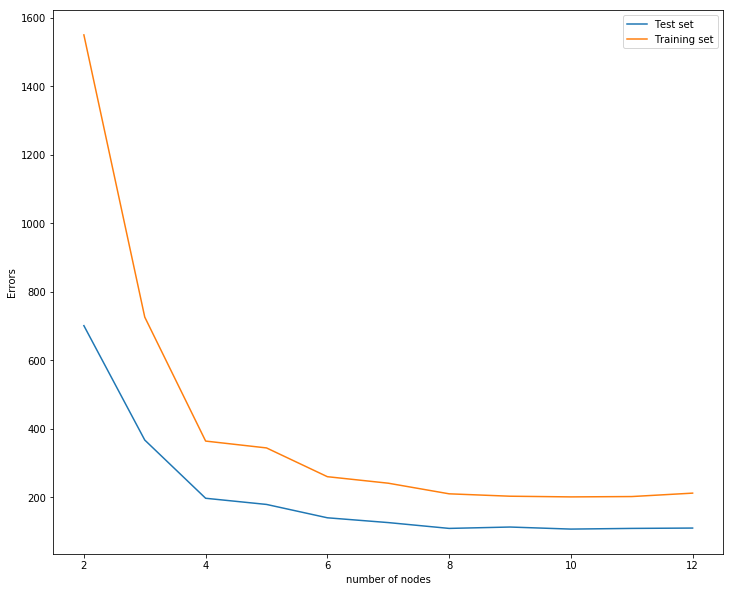

In [17]:
#GRAFICO PER VEDERE OVERFITTING
plt.subplots(1, 1, figsize=(12,10))

test, = plt.plot(max_d, errors_test, label="Test set")
training, = plt.plot(max_d, errors_training, label="Training set")
scatter_plot= plt.legend(handles=[test, training])
plt.xlabel("number of nodes")
plt.ylabel("Errors")